# script for preprocessing datacube
## 1. create .vrt files for each band

In [25]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
#import geopandas as gpd
import pandas as pd

# PATHS
# === Paths ===
VRT_FOLDER =  "/Users/felix/Documents/TUM_LOCAL/TREE/10_Data/S2_Summer_Median/VRT"  
#ALS_PATH = '/Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif'
ALS_PATH = '/Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024_processed.tif'
# CUTLINE_GEOJSON = "./als_cutline.geojson"
OUTPUT_FOLDER = "./processed"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

## Get some ALS Stats

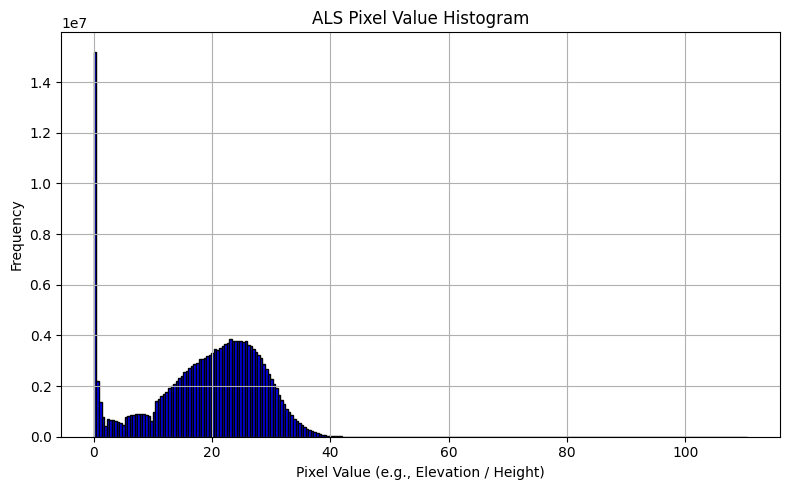

In [9]:
# plot histogram of ALS data
with rasterio.open(ALS_PATH) as src:
    als_data = src.read(1).astype(np.float32)

# === Mask out nodata and NaNs (e.g., 0 or -9999 can be nodata in ALS)
als_data = als_data[~np.isnan(als_data)]
als_data = als_data[als_data <=120]  # optional: remove zeroes if they're nodata
als_data = als_data[als_data >= 0]  # optional: filter a known nodata

# === Plot histogram ===
plt.figure(figsize=(8, 5))
plt.hist(als_data, bins=256, color='blue', edgecolor='black')
plt.title("ALS Pixel Value Histogram")
plt.xlabel("Pixel Value (e.g., Elevation / Height)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Example: 1D array of pixel values
values = als_data.flatten()
values = values[~np.isnan(values)]  # remove NaNs

# Convert to pandas and describe
desc = pd.Series(values).describe()
print(desc)

count    1.847413e+08
mean     1.880007e+01
std      9.482677e+00
min      0.000000e+00
25%      1.336000e+01
50%      2.050000e+01
75%      2.591000e+01
max      1.105100e+02
dtype: float64


### ALS Outlier removal

In [24]:
import rasterio
import numpy as np

# Open the ALS TIFF file
with rasterio.open(ALS_PATH) as src:
    als_data = src.read(1).astype(np.float32)  # Read the first band
    profile = src.profile  # Get the metadata/profile of the file

# Replace values <0 or >50 with NaN
als_data = np.where((als_data < 0) | (als_data > 50), np.nan, als_data)

# Update the profile to handle NaN values (set nodata value)
profile.update(dtype=rasterio.float32, nodata=np.nan)

# Save the processed data back to a new TIFF file
processed_tif_path = os.path.join('./data', "ALS_GT01_2024_processed.tif")
with rasterio.open(processed_tif_path, 'w', **profile) as dst:
    dst.write(als_data, 1)  # Write the processed data to the first band

print(f"✅ Processed TIFF saved to: {processed_tif_path}")

✅ Processed TIFF saved to: ./data/ALS_GT01_2024_processed.tif


## Do the S2 <> ALS DATA Wrangling
### convert to .vrt first for handling each band nicely

In [ ]:
# === CONFIG ===
root_dir = "/Users/felix/Documents/TUM_LOCAL/TREE/10_Data/S2_Summer_Median"  # <-- Change this!
recursive = True                   # Set to False if you don't want recursion
vrt_output_dir = root_dir + '/VRT'         # Where to save the VRTs

# === STEP 1: Gather all .tif files ===
tif_files = []
for root, _, files in os.walk(root_dir):
    for f in files:
        if f.lower().endswith('.tif'):
            tif_files.append(os.path.join(root, f))
    if not recursive:
        break

# === STEP 2: Group files by band suffix ===
band_groups = defaultdict(list)

pattern = re.compile(r"_SEN2L_(.+?)\.tif$", re.IGNORECASE)
for f in tif_files:
    match = pattern.search(os.path.basename(f))
    if match:
        band = match.group(1)  # e.g., "BLU_STM"
        band_groups[band].append(f)
        #print(f"Found {band} file: {f}")

if True:
# === STEP 3: Create VRTs using gdalbuildvrt ===
    for band, files in band_groups.items():
        vrt_path = os.path.join(vrt_output_dir, f"{band}.vrt")
        print(f"Creating {vrt_path} with {len(files)} files...")

        # Write file list
        list_path = os.path.join(vrt_output_dir, f"list_{band}.txt")
        with open(list_path, "w") as f:
            for tif in files:
                f.write(f"{tif}\n")

        # Call gdalbuildvrt
        subprocess.run([
            "gdalbuildvrt",
            "-input_file_list", list_path,
            vrt_path
        ], check=True)

        os.remove(list_path)

    print("✅ Done! One VRT per band has been created.")


In [9]:
print(band_groups.keys())  # print the keys of the band groups
# save the band groups to a file such that i can access only the band names (keys) as an array later   

dict_keys(['EVI_STM', 'RED_STM', 'NDV_STM', 'RE3_STM', 'NIR_STM', 'BLU_STM', 'NBR_STM', 'RE2_STM', 'SW2_STM', 'BNR_STM', 'GRN_STM', 'RE1_STM', 'SW1_STM'])


## Align S2 and ALS Data
Goal: process a data ready for training. 
1. take .vrt for each channel for the full training data.
2. for each band in bands: 
    use gdalwarp, cutline option for cropping to the Intersection with als.tif (ground-truth data)
    np.stack()
3. one big .tif -> load with rasterio -> convert to numpy / or xarray 
4. 2 img: ALS, S2. use kernel 256x256 patches
5. then do traintestvalsplit 
5. display with matplotlib (imdotshow with rgb)
6. do another check with qgis 

### use polygon cutline -> memory heavy (30GB) -> do bounding box

In [ ]:
# convert to ploygons before cutline cropping:
import os
import glob
import subprocess

# === Paths ===
VRT_FOLDER =  "/Users/felix/Documents/TUM_LOCAL/TREE/10_Data/S2_Summer_Median/VRT"  
ALS_PATH = '/Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif'
CUTLINE_GEOJSON = "./als_cutline.geojson"
OUTPUT_FOLDER = "./processed"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# === Step 1: Polygonize ALS Raster ===
if not os.path.exists(CUTLINE_GEOJSON):
    print("Creating polygon cutline from ALS raster...")
    subprocess.run([
        "gdal_polygonize.py",
        ALS_PATH,
        "-f", "GeoJSON",
        CUTLINE_GEOJSON
    ], check=True)
else:
    print("Cutline already exists, skipping polygonize.")

# === Step 2: Warp each VRT using the cutline ===
vrt_files = glob.glob(os.path.join(VRT_FOLDER, "*.vrt"))

for vrt in vrt_files:
    band_name = os.path.splitext(os.path.basename(vrt))[0]
    output_tif = os.path.join(OUTPUT_FOLDER, f"{band_name}_cropped.tif")

    if os.path.exists(output_tif):
        print(f"[SKIP] {output_tif} already exists.")
        continue

    print(f"[WARP] Cropping {band_name}...")

    cmd = [
        "gdalwarp",
        "-cutline", CUTLINE_GEOJSON,
        "-crop_to_cutline",
        "-dstalpha",  # add transparency for no-data
        "-of", "GTiff",
        "-overwrite",
        vrt,
        output_tif
    ]

    try:
        subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    except subprocess.CalledProcessError as e:
        print(f"[ERROR] gdalwarp failed for {band_name}")
        print(e.stderr.decode())

print("\n✅ All VRTs processed and cropped.")


### use bounding box cropping

In [26]:
# CROP USING BOUNDING BOX
# === Step 1: Get Bounding Box from ALS raster ===
with rasterio.open(ALS_PATH) as src:
    bounds = src.bounds  # left, bottom, right, top
    crs = src.crs

# === Step 2: Warp each VRT using bounding box ===
vrt_files = glob.glob(os.path.join(VRT_FOLDER, "*.vrt"))

for vrt in vrt_files:
    band_name = os.path.splitext(os.path.basename(vrt))[0]
    output_tif = os.path.join(OUTPUT_FOLDER, f"{band_name}_cropped.tif")

    if os.path.exists(output_tif):
        print(f"[SKIP] {output_tif} already exists.")
        continue

    print(f"[WARP] Cropping {band_name}...")

    cmd = [
        "gdalwarp",
        "-te", str(bounds.left), str(bounds.bottom), str(bounds.right), str(bounds.top),
        "-te_srs", crs.to_string(),
        "-of", "GTiff",
        "-overwrite",
        vrt,
        output_tif
    ]

    try:
        subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    except subprocess.CalledProcessError as e:
        print(f"[ERROR] gdalwarp failed for {band_name}")
        print(e.stderr.decode())

print("\n✅ All VRTs processed and cropped using bounding box.")

[SKIP] ./processed/RED_STM_cropped.tif already exists.
[SKIP] ./processed/EVI_STM_cropped.tif already exists.
[SKIP] ./processed/NDV_STM_cropped.tif already exists.
[SKIP] ./processed/GRN_STM_cropped.tif already exists.
[SKIP] ./processed/SW1_STM_cropped.tif already exists.
[SKIP] ./processed/RE1_STM_cropped.tif already exists.
[SKIP] ./processed/NBR_STM_cropped.tif already exists.
[SKIP] ./processed/BLU_STM_cropped.tif already exists.
[SKIP] ./processed/NIR_STM_cropped.tif already exists.
[SKIP] ./processed/RE3_STM_cropped.tif already exists.
[SKIP] ./processed/SW2_STM_cropped.tif already exists.
[SKIP] ./processed/BNR_STM_cropped.tif already exists.
[SKIP] ./processed/RE2_STM_cropped.tif already exists.

✅ All VRTs processed and cropped using bounding box.


### Stack S2 into one tif

In [ ]:
# === CONFIG ===

BAND_TIFS = sorted(glob.glob('./processed/*_cropped.tif'))  # e.g., [B02_cropped.tif, B03_cropped.tif, ...]
# ALS_PATH = "/full/path/to/Ebrach_Mosaik_pitt-free_nDOM_2024.tif"
STACKED_OUTPUT = "./stacked_multiband.tif"

# === STEP 1: STACK CROPPED BANDS INTO ONE MULTIBAND FILE ===
def stack_bands(band_paths, out_path):
    sample = rasterio.open(band_paths[0])
    meta = sample.meta.copy()
    meta.update(count=len(band_paths))
    
    with rasterio.open(out_path, 'w', **meta) as dst:
        for i, path in enumerate(band_paths, start=1):
            with rasterio.open(path) as src:
                dst.write(src.read(1), i)
    print(f"✅ Stacked {len(band_paths)} bands into {out_path}")
    return out_path

if os.path.exists(STACKED_OUTPUT):
    print(f"✅ Loaded existing stacked file: {STACKED_OUTPUT}")
else:
    print(f"❌ Stacked file not found. Creating new stack...")
    # stack the bands
    stack_path = stack_bands(BAND_TIFS, STACKED_OUTPUT)

✅ Loaded existing stacked file: ./stacked_multiband.tif


In [ ]:
PATCH_SIZE = 255
# === STEP 2: LOAD INTO NUMPY ===
def load_rasters(stack_path, als_path):
    with rasterio.open(stack_path) as s2_src:
        s2 = s2_src.read().astype(np.float32)  # shape: (bands, height, width)
    with rasterio.open(als_path) as als_src:
        als = als_src.read(1).astype(np.float32)  # shape: (height, width)
    print(f"✅ Loaded S2: {s2.shape}, ALS: {als.shape}")
    return s2, als

def downsample_als_to_s2(als, s2):
    """
    Downsample ALS data to match the spatial resolution of S2 data.
    Compute mean and standard deviation of ALS values for each S2 pixel.

    Parameters:
    - als: numpy array of ALS data (height, width)
    - s2: numpy array of S2 data (bands, height, width)
    # - s2_shape: tuple of S2 data shape (bands, height, width)

    Returns:
    - als_mean: numpy array of downsampled ALS mean values (height, width)
    - als_std: numpy array of downsampled ALS std values (height, width)
    """
    s2_shape = s2.shape
    s2_height, s2_width = s2_shape[1], s2_shape[2]
    als_height, als_width = als.shape

    # Compute the scaling factors
    scale_y = als_height // s2_height
    scale_x = als_width // s2_width

    # Initialize arrays for mean and std
    als_mean = np.zeros((s2_height, s2_width), dtype=np.float32)
    als_std = np.zeros((s2_height, s2_width), dtype=np.float32)

    # Compute mean and std for each S2 pixel
    for i in range(s2_height):
        for j in range(s2_width):
            y_start, y_end = i * scale_y, (i + 1) * scale_y
            x_start, x_end = j * scale_x, (j + 1) * scale_x
            als_patch = als[y_start:y_end, x_start:x_end]

            # Ignore NaN values in ALS data
            als_patch = als_patch[~np.isnan(als_patch)]
            if als_patch.size > 0:
                als_mean[i, j] = np.mean(als_patch)
                als_std[i, j] = np.std(als_patch)
            else:
                als_mean[i, j] = np.nan
                als_std[i, j] = np.nan

    print(f"✅ Downsampled ALS to S2 resolution: mean shape {als_mean.shape}, std shape {als_std.shape}")
    return als_mean, als_std

# Downsample ALS and compute mean and std
als_mean, als_std = downsample_als_to_s2(als_np, s2_np.shape)

# Add the new channels to the S2 stack
s2_with_als = np.concatenate([s2_np, als_mean[np.newaxis, :, :], als_std[np.newaxis, :, :]], axis=0)
print(f"✅ Added ALS mean and std as new channels: new shape {s2_with_als.shape}")
# === STEP 3: PATCHIFY ===
def extract_patches(s2, als, patch_size):
    _, h, w = s2.shape
    patches_s2, patches_als = [], []
    
    for i in range(0, h - patch_size + 1, patch_size):
        for j in range(0, w - patch_size + 1, patch_size):
            s2_patch = s2[:, i:i+patch_size, j:j+patch_size]
            als_patch = als[i:i+patch_size, j:j+patch_size]
            
            if not np.any(np.isnan(s2_patch)) and not np.any(np.isnan(als_patch)):
                patches_s2.append(s2_patch)
                patches_als.append(als_patch)
    
    s2_arr = np.stack(patches_s2)  # (n, bands, 256, 256)
    als_arr = np.stack(patches_als)  # (n, 256, 256)
    print(f"✅ Extracted {len(s2_arr)} patches")
    return s2_arr, als_arr

# === STEP 4: TRAIN/VAL/TEST SPLIT ===
def split_data(x, y, seed=42):
    x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=seed)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=seed)
    print(f"✅ Data split: Train={len(x_train)}, Val={len(x_val)}, Test={len(x_test)}")
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

# === STEP 5: VISUALIZATION ===
def visualize_sample(x, y, band_idxs=(11, 4, 1)):  # default: RGB R: 11 G: 4 B: 1
    rgb = x[0][band_idxs, :, :]
    als = y[0]
    
    rgb_norm = np.clip((rgb - rgb.min()) / (rgb.max() - rgb.min()), 0, 1)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(np.transpose(rgb_norm, (1, 2, 0)))
    axs[0].set_title("S2 RGB")
    #axs[0].axis("off")

    im = axs[1].imshow(als, cmap='Greens')
    axs[1].set_title("ALS Ground Truth")
    #axs[1].axis("off")

    # Add colorbar for the ALS image
    cbar = fig.colorbar(im, ax=axs[1], orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label("Height (m)")

    plt.tight_layout()
    plt.show()

# === RUN ALL ===

s2_np, als_np = load_rasters(stack_path, ALS_PATH)
s2_patches, als_patches = extract_patches(s2_np, als_np, PATCH_SIZE)
(x_train, y_train), (x_val, y_val), (x_test, y_test) = split_data(s2_patches, als_patches)

visualize_sample(x_train, y_train)


✅ Loaded S2: (13, 846, 1241), ALS: (16910, 24821)


ValueError: need at least one array to stack

In [13]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import glob
import os

# === INPUTS ===
#ALS_PATH = "/full/path/to/Ebrach_Mosaik_pitt-free_nDOM_2024.tif"
S2_BAND_PATHS = sorted(glob.glob("./processed/*_cropped.tif"))
PATCH_SIZE = 256

# === Load ALS reference grid ===
with rasterio.open(ALS_PATH) as als_src:
    als = als_src.read(1).astype(np.float32)
    als_profile = als_src.profile
    als_transform = als_src.transform
    als_shape = als.shape
    als_crs = als_src.crs

# === Reproject & resample each S2 band to ALS grid ===
stacked_bands = []

for path in S2_BAND_PATHS:
    with rasterio.open(path) as s2_src:
        s2_data = s2_src.read(1).astype(np.float32)
        s2_reproj = np.full(als_shape, np.nan, dtype=np.float32)

        reproject(
            source=s2_data,
            destination=s2_reproj,
            src_transform=s2_src.transform,
            src_crs=s2_src.crs,
            dst_transform=als_transform,
            dst_crs=als_crs,
            resampling=Resampling.bilinear
        )

        stacked_bands.append(s2_reproj)

s2_stack = np.stack(stacked_bands)  # shape: (bands, H, W)
print(f"✅ Resampled and stacked to shape: {s2_stack.shape} (matching ALS: {als.shape})")


✅ Resampled and stacked to shape: (13, 16910, 24821) (matching ALS: (16910, 24821))


In [ ]:
S2_BAND_PATHS = sorted(glob.glob("./processed/*_cropped.tif"))

def get_gsd(path):
    with rasterio.open(path) as src:
        res_x, res_y = src.res  # (pixel width, pixel height in coordinate units)
        crs = src.crs
        print(f"{os.path.basename(path)}:")
        print(f"  CRS: {crs}")
        print(f"  Ground Sampling Distance (GSD): {res_x:.2f} x {res_y:.2f} {crs.linear_units}\n")

# Example usage
get_gsd(ALS_PATH)
for path in S2_BAND_PATHS:
    get_gsd(path)



ALS_GT01_2024.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 0.50 x 0.50 metre

BLU_STM_cropped.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

BNR_STM_cropped.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

EVI_STM_cropped.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

GRN_STM_cropped.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

NBR_STM_cropped.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

NDV_STM_cropped.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

NIR_STM_cropped.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

RE1_STM_cropped.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

RE2_STM_cropped.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

RE3_STM_cropped.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 

In [7]:
import os
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.windows import Window
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

# === CONFIG ===
VRT_DIR =  "/Users/felix/Documents/TUM_LOCAL/TREE/10_Data/S2_Summer_Median/VRT"  
ALS_PATH = '/Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif'
#'/Users/felix/Documents/TUM_LOCAL/TREE/10_Data/Ebrach_Mosaik_pitt-free_nDOM_2024/Ebrach_Mosaik_pitt-free_nDOM_2024.tif'
OUTPUT_DIR = "./processed"
PATCH_SIZE = 256
BANDS = ['EVI_STM', 'RED_STM', 'NDV_STM', 'RE3_STM', 'NIR_STM', 'BLU_STM', 'NBR_STM', 'RE2_STM', 'SW2_STM', 'BNR_STM', 'GRN_STM', 'RE1_STM', 'SW1_STM']

os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Step 1: Warp VRTs to ALS extent ===
aligned_bands = []
for band in BANDS:
    vrt = os.path.join(VRT_DIR, f"{band}.vrt")
    warped = os.path.join(OUTPUT_DIR, f"{band}_cropped.tif")
    cmd = [
        "gdalwarp",
        "-cutline", ALS_PATH,
        "-crop_to_cutline",
        "-of", "GTiff",
        vrt, warped
    ]
    print(f"Cropping {band}...")
    os.system(" ".join(cmd))
    aligned_bands.append(warped)

# === Step 2: Stack bands into a single raster ===
print("Stacking bands...")
with rasterio.open(aligned_bands[0]) as src0:
    meta = src0.meta.copy()
    meta.update(count=len(BANDS))

    stacked_path = os.path.join(OUTPUT_DIR, "S2_stack.tif")
    with rasterio.open(stacked_path, 'w', **meta) as dst:
        for idx, band_path in enumerate(aligned_bands, start=1):
            with rasterio.open(band_path) as src:
                dst.write(src.read(1), idx)

# === Step 3: Load ALS and S2 stack as numpy arrays ===
with rasterio.open(stacked_path) as s2, rasterio.open(ALS_PATH) as als:
    assert s2.shape == als.shape, "Shape mismatch after cropping!"
    s2_data = s2.read()  # shape: (bands, height, width)
    als_data = als.read(1)  # shape: (height, width)

# === Step 4: Patch extraction ===
print("Extracting patches...")
patches_s2 = []
patches_als = []

h, w = als_data.shape
for i in tqdm(range(0, h - PATCH_SIZE, PATCH_SIZE)):
    for j in range(0, w - PATCH_SIZE, PATCH_SIZE):
        patch_s2 = s2_data[:, i:i+PATCH_SIZE, j:j+PATCH_SIZE]
        patch_als = als_data[i:i+PATCH_SIZE, j:j+PATCH_SIZE]

        if np.any(patch_als == als.nodata):  # Skip no-data patches
            continue

        patches_s2.append(patch_s2)
        patches_als.append(patch_als)

patches_s2 = np.stack(patches_s2)  # shape: (N, bands, H, W)
patches_als = np.stack(patches_als)  # shape: (N, H, W)

# === Step 5: Train/Val/Test Split ===
print("Splitting dataset...")
X_train, X_temp, y_train, y_temp = train_test_split(patches_s2, patches_als, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# === Step 6: Visualization ===
def show_rgb(image_stack, idx=0):
    rgb = np.transpose(image_stack[idx, [2, 1, 0], :, :], (1, 2, 0))
    rgb = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb))  # normalize
    plt.imshow(rgb)
    plt.title("RGB Patch")
    plt.axis("off")
    plt.show()

show_rgb(X_train)

# === Optional: Save output arrays ===
np.savez_compressed(os.path.join(OUTPUT_DIR, "dataset.npz"),
                    X_train=X_train, y_train=y_train,
                    X_val=X_val, y_val=y_val,
                    X_test=X_test, y_test=y_test)


Cropping EVI_STM...
Cropping RED_STM...
Cropping NDV_STM...
Cropping RE3_STM...
Cropping NIR_STM...
Cropping BLU_STM...


ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.
ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.
ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.
ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.
ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.
ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.


Cropping NBR_STM...
Cropping RE2_STM...
Cropping SW2_STM...
Cropping BNR_STM...
Cropping GRN_STM...
Cropping RE1_STM...


ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.
ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.
ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.
ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.
ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.
ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.


Cropping SW1_STM...
Stacking bands...


ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.


RasterioIOError: ./processed/EVI_STM_cropped.tif: No such file or directory

In [6]:
import rasterio
with rasterio.open(ALS_PATH) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.3999999521443642e+38, 'width': 24821, 'height': 16910, 'count': 1, 'crs': CRS.from_wkt('PROJCS["ETRS89 / UTM zone 32N",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","25832"]]'), 'transform': Affine(0.5, 0.0, 601191.0001220703,
       0.0, -0.5, 5528384.50012207), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [11]:
ALS_PATH = "/Users/felix/Documents/TUM_LOCAL/TREE/10_Data/Ebrach_Mosaik_pitt-free_nDOM_2024/Ebrach_Mosaik_pitt-free_nDOM_2024.tif"
gt = open(ALS_PATH, 'r')

In [13]:
print(gt)

<_io.TextIOWrapper name='/Users/felix/Documents/TUM_LOCAL/TREE/10_Data/Ebrach_Mosaik_pitt-free_nDOM_2024/Ebrach_Mosaik_pitt-free_nDOM_2024.tif' mode='r' encoding='UTF-8'>


In [3]:
from gdal import processing

processing.run("gdal:polygonize", {'INPUT':'/Users/felix/Documents/TUM_LOCAL/TREE/10_Data/Ebrach_Mosaik_pitt-free_nDOM_2024/Ebrach_Mosaik_pitt-free_nDOM_2024.tif','BAND':1,'FIELD':'ALS_Vector','EIGHT_CONNECTEDNESS':False,'EXTRA':'','OUTPUT':'TEMPORARY_OUTPUT'})

ModuleNotFoundError: No module named 'gdal'